In [4]:
import pandas as pd
import pickle
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import download_airnow_web
import pyproj
%matplotlib inline
import numpy as np
from calibration.dataprocessing import plotsensorencounters,build_encounters,combinedatasets,loaddata,processBAMdata

# Download and organise data

The following code can take a while as it downloads data from servers and merges big dataframes. If you want to analyse the data and have already downloaded it - you might be best skipping straight to the analysis step below.

This method takes a long time as it downloads data from GCP.
Typically I comment it out and just use the local copy.

In [2]:
import pickle
#airqodf = loaddata("/home/mike/.gcp_keys/airqo-250220-e1dc140554a6.json",nextdays=20,since='2020-07-15')
#pickle.dump(airqodf,open('airqodf2.p','wb'))
airqodf = pickle.load(open('airqodf2.p','rb')) #just data from July 15th 2020 onwards

In [3]:
#sensor 1014687 is colocated with ref sensor 24517, but the lat/long are missing
#so I'm adding them in manually here.
airqodf.loc[airqodf['channel_id']==1014687,'latitude']=0.331705
airqodf.loc[airqodf['channel_id']==1014687,'longitude']=32.609860

Download latest embassy data, add its latitude, longitude, channel_id (-1) and add new columns renaming them to our conventions.

In [4]:
embassydf = download_airnow_web.download('Kampala')
embassydf['pm2_5'] = embassydf['Raw Conc.']
embassydf['created_at'] = embassydf['Date (LT)']
embassydf['channel_id']=-1
embassydf['latitude'] = 0.299333
embassydf['longitude'] = 32.592539

In [5]:
print("Most recent datapoint is on %s." % (embassydf['created_at'].max()))

Most recent datapoint is on 2021-02-09 12:00 AM.


The BAM data has been copied from the google folder Joel set up. This method parses that data and converts to a dataframe.

In [6]:
bamdf = processBAMdata('/home/mike/Documents/Research/air/BAM Data',{'Y24517':-24517,'Y24516':-24516})

Device Ids: 
['Y24517' 'Y24516']


I found that I ran out of memory doing some of this, so I drop many of the columns from the GCP airqo database.

In [7]:
airqodf = airqodf.drop(['entry_id','pm10','voltage','s2_pm10','altitude','wind','no_sats','hdope'],axis=1)

Here we move everything to UTC:
- the AirQo data is already in UTC
- the BAM and Embassy data are in local time, so they get converted.

We then call our 'combinedatasets' method to merge the three sets together, and save them.

In [8]:
airqodf['created_at'] = airqodf['created_at'].dt.tz_localize('UTC')
bamdf['created_at'] = pd.to_datetime(bamdf['Time'],format="%Y-%m-%d %H:%M:%S").dt.tz_localize('Africa/Kampala').dt.tz_convert('UTC')
embassydf['created_at'] = pd.to_datetime(embassydf['created_at'],format="%Y-%m-%d %I:%M %p").dt.tz_localize('Africa/Kampala').dt.tz_convert('UTC')

df = combinedatasets(airqodf,bamdf)
df = combinedatasets(df,embassydf)
pickle.dump(df,open('alldataprocessed.p','wb'))

/home/mike/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/mike/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/mike/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making

KeyboardInterrupt: 

# Analysis

The above processing and collecting of the data is quite time consuming, so to use a saved version we just can start here.

In [5]:
df = pickle.load(open('alldataprocessed.p','rb'))

In [6]:
#just use recent data
df = df[df['created_at']>pd.Timestamp('2020-07-15',tz='UTC')]

Here we build the encounters dataframe, this records all the times two sensors are near each other.
It can take a few minutes, so if you've already run it - skip to loading it on the next line.

In [10]:
#min(df['created_at']) + (max(df['created_at'])-min(df['created_at']))/2
#2020-07-15 to 2020-10-22
#2020-09-02 is the middle
#df.loc[(df['created_at']>pd.Timestamp('2020-09-02',tz='UTC')) & (df['channel_id']==-1),'channel_id'] = -2

#td=(df['created_at']-pd.Timestamp('2020-07-15',tz='UTC'))
#simnoncalsensor = (td/pd.Timedelta(hours=1))%48<24
#df.loc[simnoncalsensor & (df['channel_id']==-1),'channel_id'] = -2


#pickle.dump(df,open('alldataprocessed_embassycopy.p','wb'))
df = pickle.load(open('alldataprocessed_embassycopy.p','rb'))

In [11]:
#encounters = build_encounters(df,prox=40)
#pickle.dump(encounters,open('encounters_embassycopy.p','wb'))
encounters = pickle.load(open('encounters_embassycopy.p','rb'))

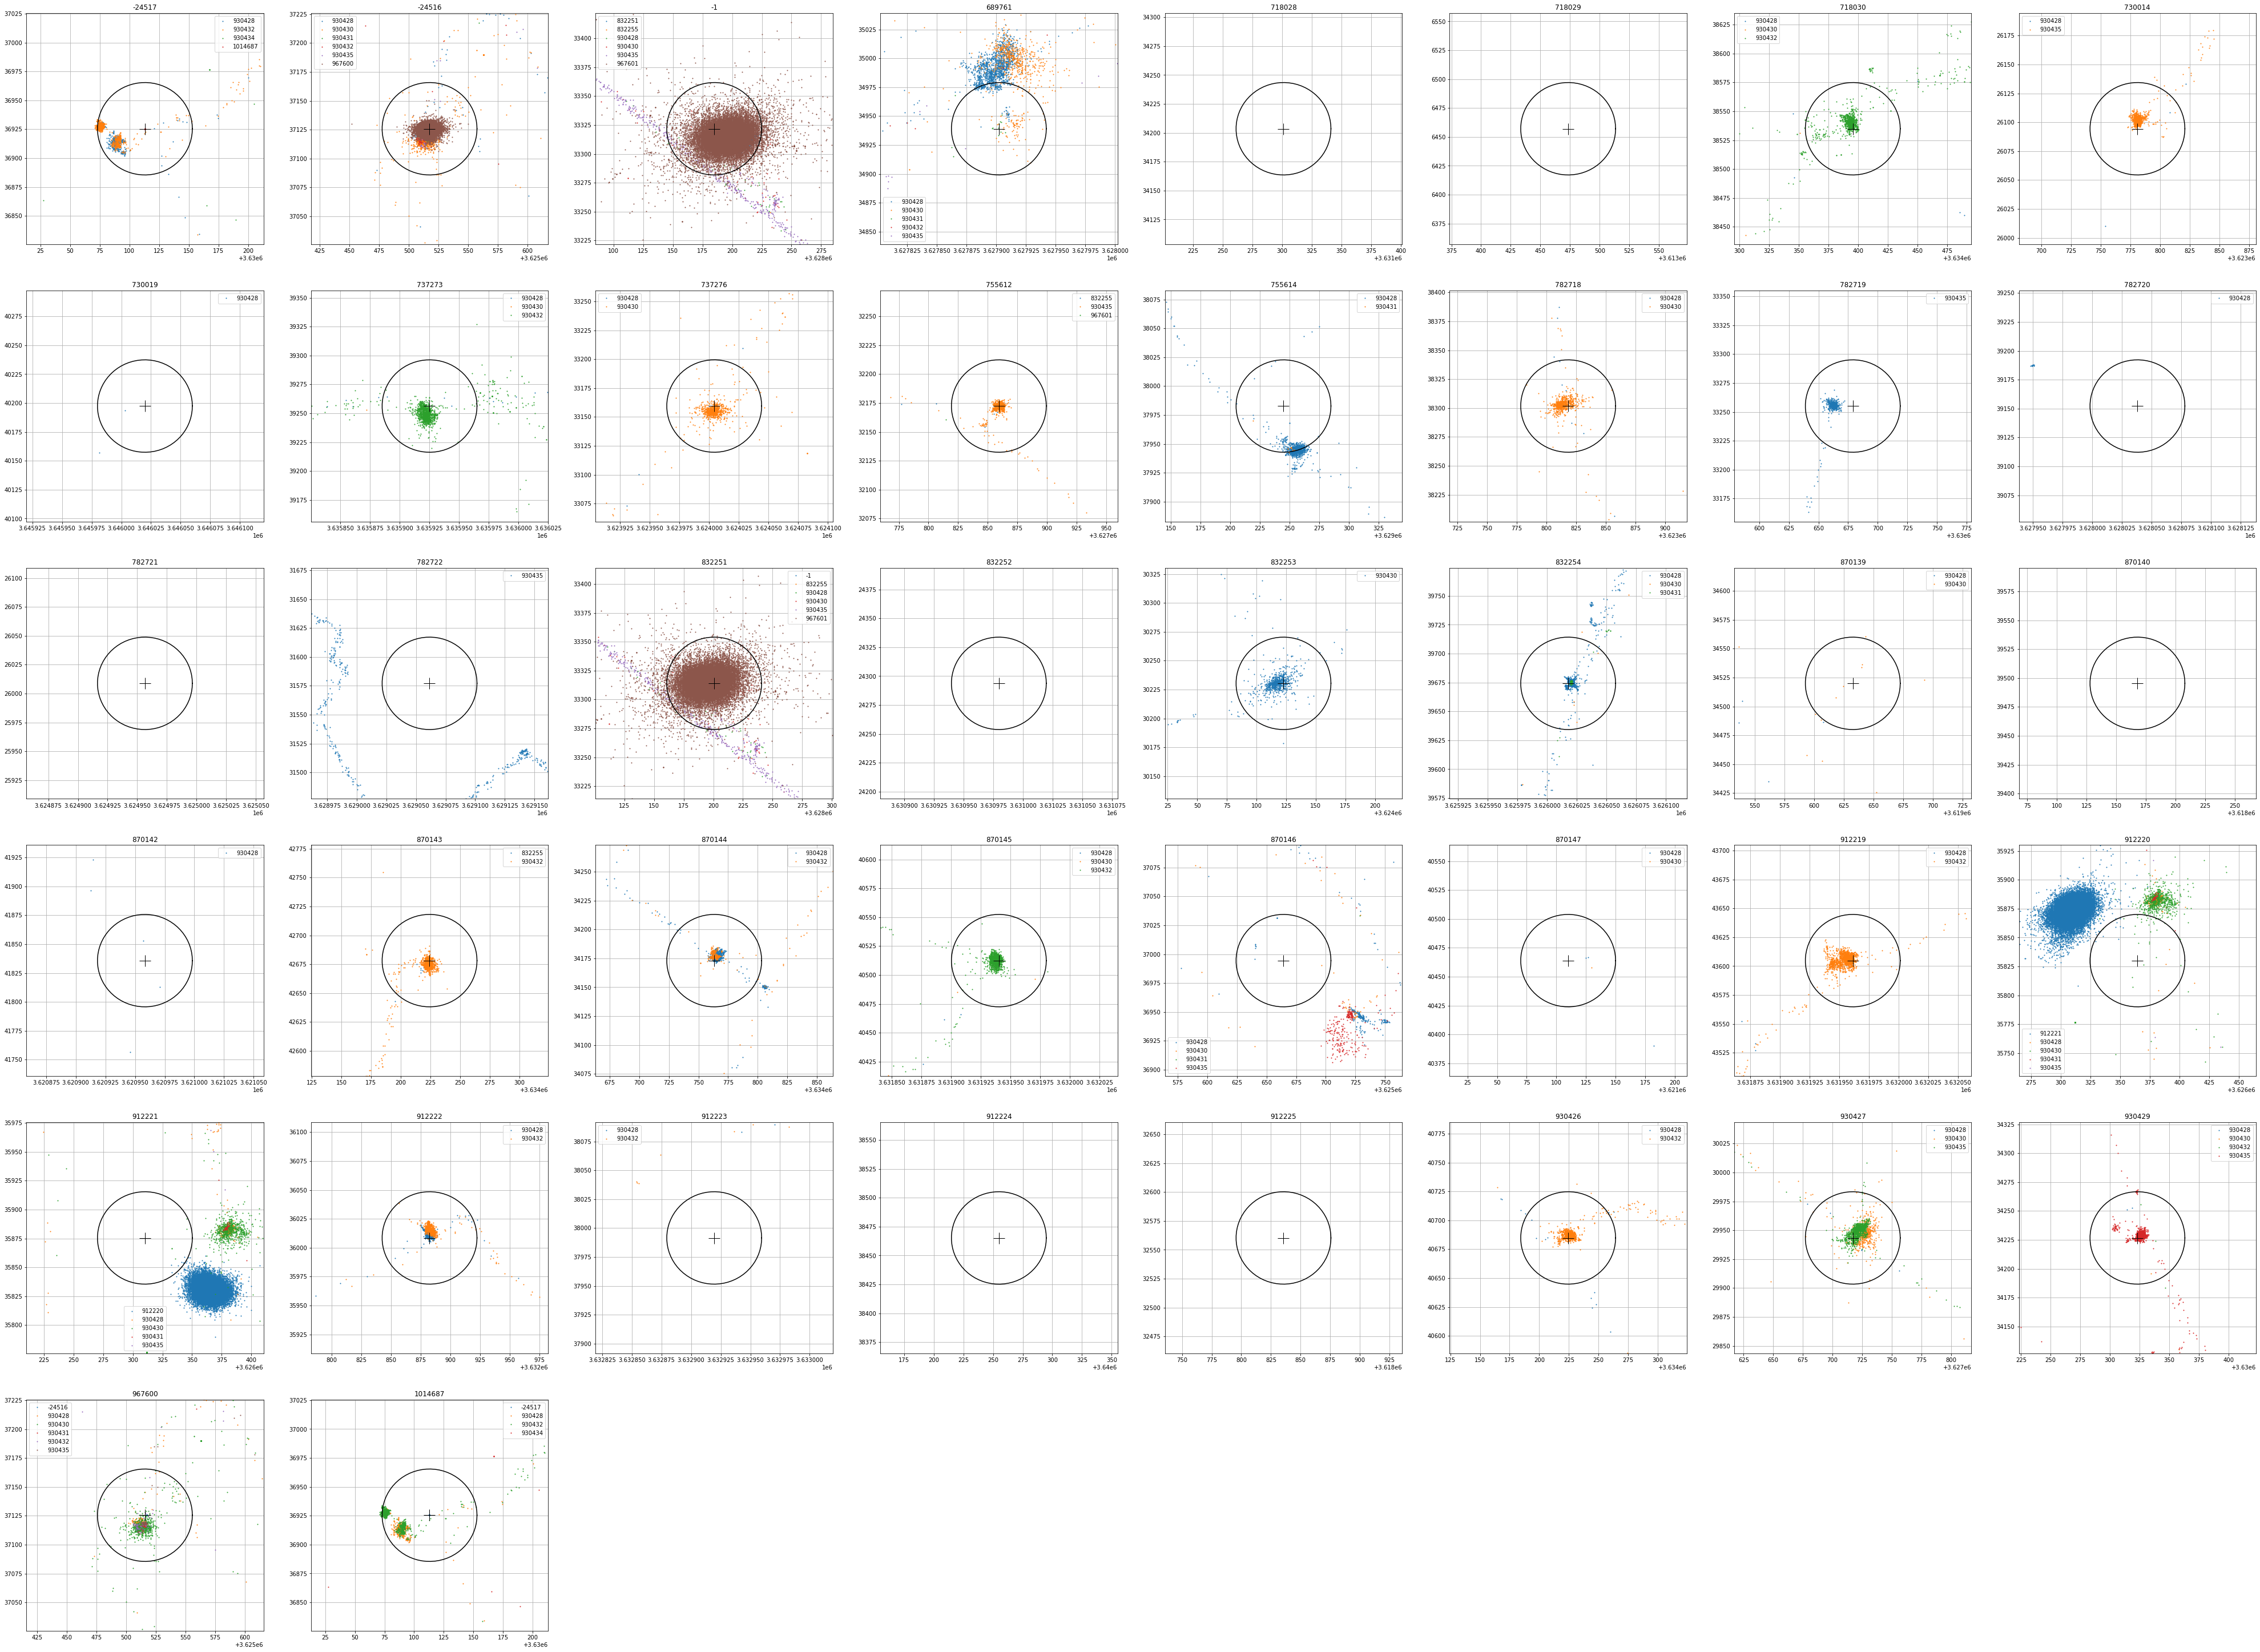

In [12]:
box = 100
plti=1
radius = 40
plt.figure(figsize=[70,70])
for sid in np.unique(df['channel_id']):
    sensor_df = df[df['channel_id']==sid]
    x=np.median(sensor_df['x'])
    y=np.median(sensor_df['y'])

    if np.mean(np.diff(sensor_df['x'])**2)<40**2:
        plt.subplot(8,8,plti)
        plt.title(sid)
        plti+=1
        other_df = df[(df['x']>x-box) & (df['x']<x+box) & (df['y']>y-box) & (df['y']<y+box)]
        for other_id in np.unique(other_df['channel_id']):
            if other_id == sid: continue #don't plot the current sensor
            odf = other_df[other_df['channel_id']==other_id]
            plt.plot(odf['x'],odf['y'],'.',markersize=2,label=other_id)
            plt.legend()
        plt.xlim(x-box,x+box)
        plt.ylim(y-box,y+box)
        a = np.linspace(0,2*np.pi+0.001,70)
        plt.plot(x+np.cos(a)*radius,y+np.sin(a)*radius,'k-')
        plt.grid()
        plt.plot(x,y,'k+',markersize=20)
        

# Plot Map

In [13]:
import geopandas
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [14]:
df

,created_at,channel_id,pm2_5,s2_pm2_5,latitude,longitude,temperature,humidity,x,y
10,2020-07-28 08:55:04+00:00,912222,43.68,41.37,0.323460,32.634727,0.0,27759.0,3.632881e+06,36007.593759
15,2020-07-25 13:46:11+00:00,870145,126.05,113.45,0.363895,32.626320,0.0,0.0,3.631945e+06,40508.878440
16,2020-07-29 11:29:56+00:00,870146,39.70,44.22,0.332327,32.569859,0.0,0.0,3.625660e+06,36994.679849
17,2020-07-29 11:32:45+00:00,870146,40.02,43.78,0.332315,32.569859,0.0,0.0,3.625660e+06,36993.343992
18,2020-07-29 11:34:07+00:00,870146,40.83,43.47,0.332312,32.569862,0.0,0.0,3.625660e+06,36993.010028
...,...,...,...,...,...,...,...,...,...,...
58,2021-02-03 17:00:00+00:00,-1,56.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717
59,2021-02-03 18:00:00+00:00,-1,75.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717
60,2021-02-03 19:00:00+00:00,-1,88.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717
61,2021-02-03 20:00:00+00:00,-1,70.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717


In [15]:
unq = np.unique(df['channel_id'])
refsensor = (unq==-24516).astype(int)
testsensor = (unq==-24517).astype(int)
mobile = [np.mean(np.abs(np.diff(df[df['channel_id']==sid]['x'])))>10 for sid in unq]

In [16]:
meanx,meany = np.mean(df[df['channel_id']==sid][['x','y']],0)

In [17]:
keepids = set([ 912222,  930428,  930432,  870145,  912220,  912221,  930430,
        689761,  930427,  930435,  967601,  737276,  832253,  782718,
        967600,  832251,  782719,  930434,  755612,  730014,      -1,
        737273,  870144,  870143,  832254,  755614, 1014687,  -24516,
        930426,  912219,  -24517])

In [24]:
unq[np.where(mobile)]

array([832255, 930428, 930430, 930431, 930432, 930435])

50

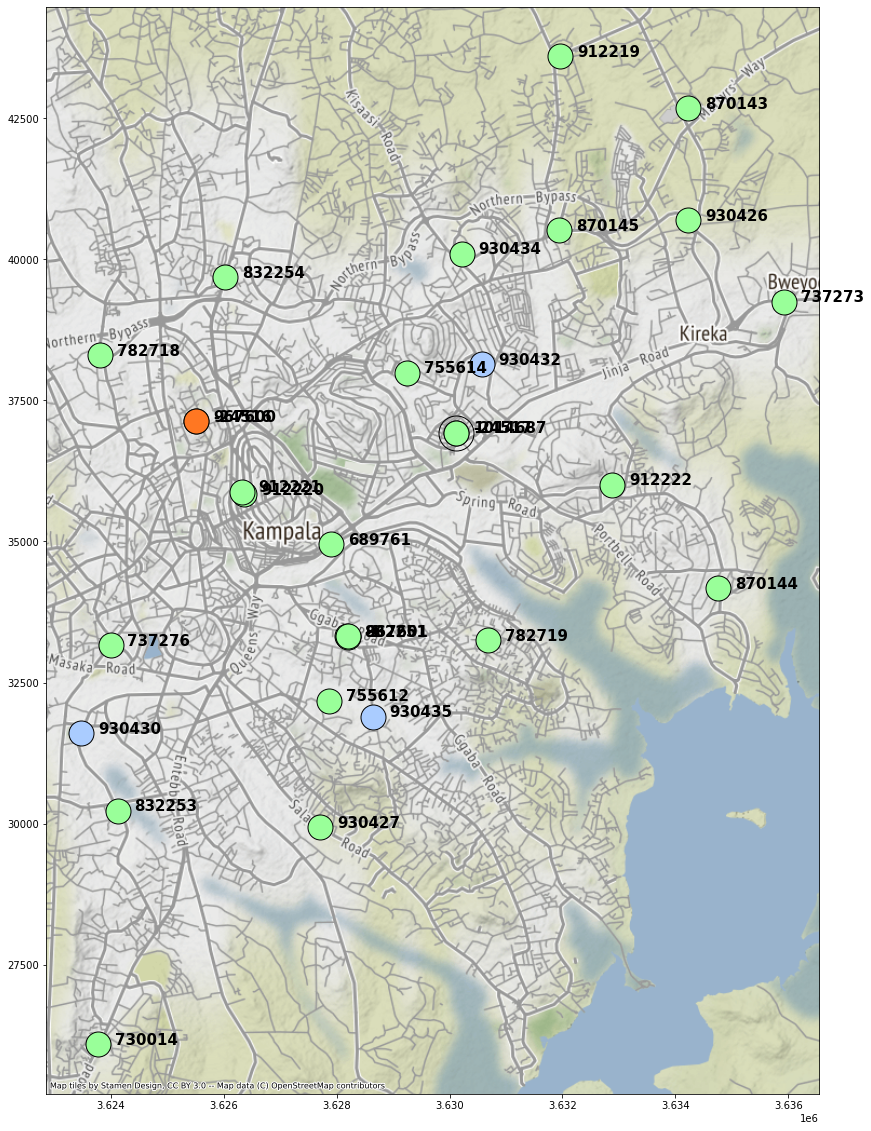

In [96]:
boxsize = 12e3
plt.figure(figsize=[20,20])
for sid in unq:#
    if sid not in keepids: continue
    c = '#99ff99'
    idx = np.where(unq==sid)[0][0]
    if refsensor[idx]: c = '#ff7722'
    if mobile[idx]: c = '#aaccff'
    
    x,y = df[df['channel_id']==sid][['x','y']].iloc[-1]
    if (x<meanx-boxsize) | (x>meanx+boxsize) | (y<meany-boxsize) | (y>meany+boxsize): continue
    zorder = 1+refsensor[idx]+testsensor[idx]
    plt.plot(x,y,'o',markersize=25,color=c,zorder=zorder,markeredgecolor='black')
    if testsensor[idx]:
        plt.plot(x,y,'o',markersize=35,color='none',zorder=zorder,markeredgecolor='black')
    plt.text(x+300,y,"%d" % sid,weight='bold',fontsize=15)
ax = plt.gca()
ctx.add_basemap(ax,zoom=13)
plt.savefig('networkmap.pdf')